#Task

Visualize words in a 2- or 3-dimensional space using the embeddings given by GloVe (https://nlp.stanford.edu/projects/glove/) and word2vec (https://code.google.com/archive/p/word2vec/): \
a) by choosing randomly the dimensions\
b) by using PCA or/and tSNE to extract 2- or 3-dimensional embedding




#Imports

In [ ]:
!pip install nltk
!pip install gensim
!pip install glove-python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import pandas as pd
import numpy as np
import warnings
import re 
import gensim
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
from glove import Corpus, Glove
from sklearn.manifold import TSNE
from scipy import spatial

pd.options.mode.chained_assignment = None 
warnings.filterwarnings(action = 'ignore')
nltk.download('punkt')
nltk.download('stopwords')

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Making the corpus

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/train.csv').sample(50000, random_state=23)

STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

data = clean_dataframe(data)
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
237921,237921,9732,79801,sex relationship,sex important relationship,1
181001,181001,277377,277378,inspiring start stories,inspirational stories,0
294691,294691,150129,93109,digital marketing,unique ways digital marketing,1
104145,104145,171986,171987,grow facebook page,followers facebook page,1
357893,357893,487310,487311,suppose host sends tcp segments back back host...,suppose host sends tcp segments back back host...,1


In [ ]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:10]

[['sex', 'relationship'],
 ['inspiring', 'start', 'stories'],
 ['digital', 'marketing'],
 ['grow', 'facebook', 'page'],
 ['suppose',
  'host',
  'sends',
  'tcp',
  'segments',
  'back',
  'back',
  'host',
  'b',
  'tcp',
  'connection',
  'segment',
  'sequence',
  'number',
  '140',
  'sequence',
  'number',
  '170'],
 ['sahara', 'average', 'temperatures', 'compare', 'dashte', 'loot'],
 ['possible', 'disable', 'facetimes', 'call', 'button'],
 ['agencies', 'fulfil', 'sex', 'fantasies', 'usa'],
 ['signs', 'mentally', 'weak'],
 ['different', 'quora']]

# GloVe

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. The model is trained on the non-zero entries of a global word-word co-occurrence matrix, which tabulates how frequently words co-occur with one another in a given corpus. Populating this matrix requires a single pass through the entire corpus to collect the statistics.

In [ ]:
training_corpus = Corpus() 

#Training the corpus to generate the co-occurrence matrix which is used in GloVe.
training_corpus.fit(corpus, window=10)

glove = Glove(no_components=100, learning_rate=0.05) 
glove.fit(training_corpus.matrix, epochs=15, no_threads=4, verbose=True)

glove.add_dictionary(training_corpus.dictionary)

Performing 15 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14


In [ ]:
# print(glove.word_vectors)
print(glove.dictionary)
print(glove.word_vectors[glove.dictionary['engineer']])

{'sex': 0, 'relationship': 1, 'inspiring': 2, 'start': 3, 'stories': 4, 'digital': 5, 'marketing': 6, 'grow': 7, 'facebook': 8, 'page': 9, 'suppose': 10, 'host': 11, 'sends': 12, 'tcp': 13, 'segments': 14, 'back': 15, 'b': 16, 'connection': 17, 'segment': 18, 'sequence': 19, 'number': 20, '140': 21, '170': 22, 'sahara': 23, 'average': 24, 'temperatures': 25, 'compare': 26, 'dashte': 27, 'loot': 28, 'possible': 29, 'disable': 30, 'facetimes': 31, 'call': 32, 'button': 33, 'agencies': 34, 'fulfil': 35, 'fantasies': 36, 'usa': 37, 'signs': 38, 'mentally': 39, 'weak': 40, 'different': 41, 'quora': 42, 'find': 43, 'list': 44, 'gmail': 45, 'addresses': 46, 'resources': 47, 'learning': 48, 'hana': 49, 'business': 50, 'opportunities': 51, 'india': 52, 'coding': 53, 'language': 54, 'learn': 55, 'making': 56, 'games': 57, 'interesting': 58, 'products': 59, 'innovations': 60, 'brands': 61, 'coming': 62, '2016': 63, 'question': 64, 'marked': 65, 'needing': 66, 'improvement': 67, 'make': 68, 'invis

In [ ]:
glove.most_similar('engineer', number=10)


[('engineers', 0.9664348445095198),
 ('software', 0.9483037197913007),
 ('mechanical', 0.9373517130199844),
 ('field', 0.9358663918796256),
 ('engineering', 0.9341303258898604),
 ('btech', 0.9248105385134313),
 ('electrical', 0.9231148130512319),
 ('structural', 0.8958827455744046),
 ('electronics', 0.8954969900446921)]

## tSNE visualisation

### 2D

In [ ]:
def tsne_plot2d(model):
    "Creates the TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.dictionary.keys():
        tokens.append(model.word_vectors[model.dictionary[word]])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
tsne_plot2d(glove)

### 3D

In [ ]:
import plotly.express as px
def tsne_plot3d(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.dictionary.keys():
        tokens.append(model.word_vectors[model.dictionary[word]])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    z = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        z.append(value[2])

    fig = px.scatter_3d(new_values, x,y,z, color = x, symbol = labels)
    fig.show()

In [ ]:
tsne_plot3d(glove)

# word2vec

In [ ]:
model = Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['engineer']

array([ 0.4433449 ,  0.14174445, -0.5546764 ,  0.29389882, -0.62585515,
        0.34066477,  0.2779422 , -0.11866382, -0.49502516, -0.256667  ,
        0.12630406, -0.05218701, -0.4481315 , -0.38421845, -0.70272094,
        0.32412493, -0.6412442 ,  0.45669034,  0.50776064, -0.47467288,
        0.2550426 ,  0.65001637, -0.38033232, -0.13089454,  0.14555326,
       -0.21049365, -0.10228773, -0.21405423, -0.3743532 , -0.20732649,
        0.27410707,  0.48638296,  0.06359088,  0.18632528,  1.292019  ,
       -0.30696955,  0.30600104, -0.16338971, -0.31403863, -0.62422204,
       -0.08005948, -0.2274926 ,  0.32783425, -0.5184113 ,  0.3705461 ,
       -0.04579943, -0.05837977, -0.13702786,  0.07676386,  0.31152824,
        0.8428384 , -0.00197911,  0.34647682, -0.35645682,  0.06784754,
       -0.1781125 ,  0.20535718,  0.12734553,  0.55957735, -0.35030606,
        0.30628958, -0.07922199,  0.16991343, -0.14492269, -0.17202291,
        0.46486753,  0.668997  ,  0.42692557,  0.62829864, -0.12

## tSNE visualisation

### 2D

In [ ]:
def tsne_plot2d(model):
    "Creates the TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
print(model.wv.vocab)
print(model['relationship'])

{'sex': <gensim.models.keyedvectors.Vocab object at 0x7f0ecb21af10>, 'relationship': <gensim.models.keyedvectors.Vocab object at 0x7f0ecbe74190>, 'start': <gensim.models.keyedvectors.Vocab object at 0x7f0ecbe74bd0>, 'digital': <gensim.models.keyedvectors.Vocab object at 0x7f0ecbe749d0>, 'marketing': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b50610>, 'facebook': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b506d0>, 'back': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b50710>, 'number': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b50750>, 'average': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b50590>, 'compare': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b50650>, 'possible': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b50790>, 'call': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b507d0>, 'usa': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b50810>, 'different': <gensim.models.keyedvectors.Vocab object at 0x7f0ed0b50850

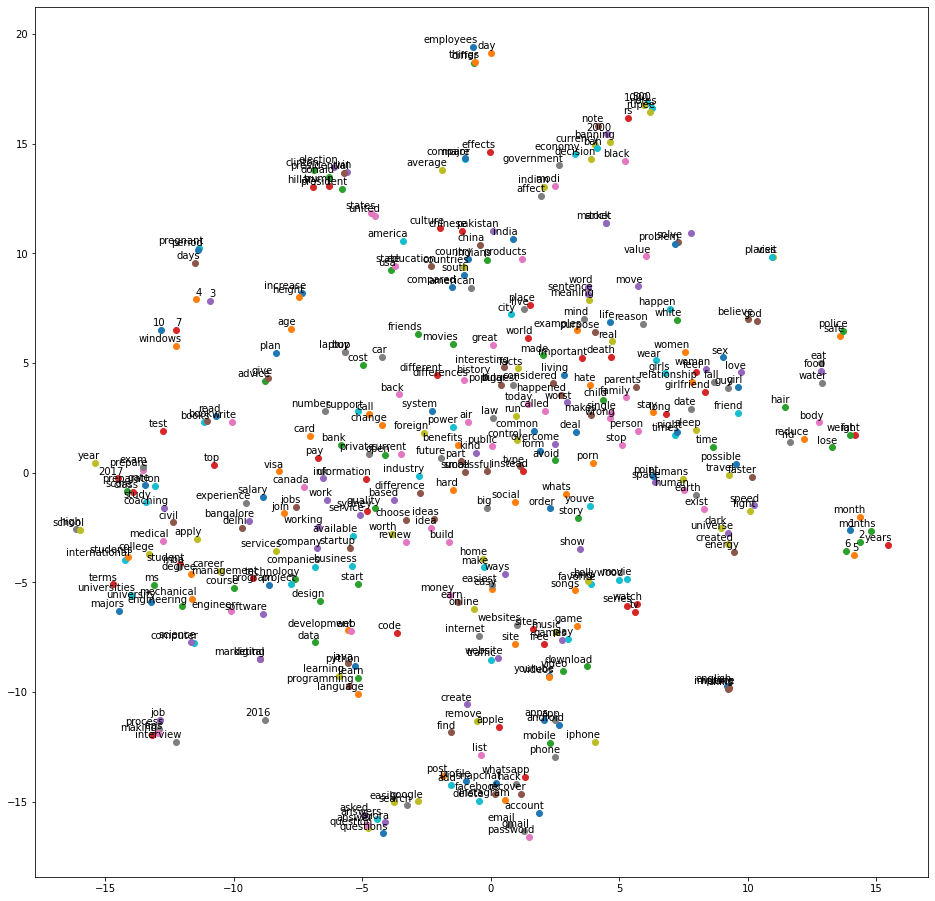

[('mechanical', 0.9234431385993958),
 ('software', 0.9197497367858887),
 ('working', 0.9045025110244751),
 ('engineering', 0.8893301486968994),
 ('career', 0.8834871649742126),
 ('degree', 0.8760855197906494),
 ('management', 0.8670350313186646),
 ('project', 0.8561153411865234),
 ('jobs', 0.8331307768821716),
 ('mba', 0.8262953758239746)]

In [ ]:
tsne_plot2d(model)
model.most_similar('engineer')

### 3D

In [ ]:
import plotly.express as px
def tsne_plot3d(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    z = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        z.append(value[2])

    # plt.figure(figsize=(16, 16, 16))
    # for i in range(len(x)):
    #     plt.scatter_3d(x[i],y[i],z[i])
    #     plt.annotate(labels[i],
    #                  xy=(x[i], y[i], z[i]),
    #                  xytext=(5, 2),
    #                  textcoords='offset points',
    #                  ha='right',
    #                  va='bottom')
    fig = px.scatter_3d(new_values, x,y,z, color = x, symbol = labels)
    fig.show()

In [ ]:
tsne_plot3d(model)

In [ ]:
model.most_similar('country')

[('china', 0.9435861706733704),
 ('countries', 0.9278914928436279),
 ('pakistan', 0.9127857089042664),
 ('south', 0.9125034809112549),
 ('city', 0.8896083235740662),
 ('indians', 0.8755724430084229),
 ('india', 0.8721154928207397),
 ('american', 0.8462127447128296),
 ('america', 0.8331580758094788),
 ('products', 0.8196815252304077)]